Standard prelude:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import itertools as it
import functools as ft

import numpy as np
np.random.seed(0)

import linear_algebra_helpers as la

In [2]:
# For convenience...
def make_palette(items):
    n = len(items)
    def _make_palette(i):
        return items[i%n]
    return _make_palette

color_palette = make_palette(plt.rcParams['axes.prop_cycle'].by_key()['color'])
default_color = color_palette(0)

default_size = plt.rcParams['lines.markersize']

# Universal Scatter Plots
Towards universal plotting function for n-dimensional data. Aka parallel coordinates are just scatter plots in disguise...

## Preliminaries
The purpose of this notebook is to package the technique developed in the previous part into something more production ready. We start by specifying some of the data types that we will use.

In [3]:
# Define the data types
M, N = 9, 2

MARK_TYPE = [
    ('position', np.float32, (M+1)),
    ('size', np.float32),
    ('color', np.object_),
]
VIEW_TYPE = [
    ('transform', np.float32, (M+1,N+1)),
    ('color', np.object_),
]
RESULT_TYPE = [
    ('position', np.float32, (N+1)),
    ('size', np.float32),
    ('color', np.object_),
]

Finally, as before, we generate some random data.

In [4]:
P = 10
mark_data = np.empty(P, dtype=MARK_TYPE)
mark_data['position'] = np.concatenate((np.random.randn(P,M), np.ones((P,1))), axis=1)
mark_data['color'] = np.array([color_palette(i) for i in range(P)], dtype=np.object_)
mark_data['size'] = (10*(np.random.rand(P) + 1))

model = la.transform_normalise(mark_data['position']) @ la.transform_scale([0.8]*M)

In [5]:
# Single View
Q = 1
view0_data = np.empty(Q, dtype=VIEW_TYPE) 
view0_data['transform'] = [model @ la.transform_unit_cols([0,1], M, N)]
view0_data['color'] = np.array([color_palette(i) for i in range(Q)], dtype=np.object_)

In [6]:
# Multiple Views
Q = M
view1_data = np.empty(Q, dtype=VIEW_TYPE) 
view1_data['transform'] = [model @ la.transform_parallel_coordinates(i, M, N) for i in range(M)]
view1_data['color'] = np.array([color_palette(i) for i in range(Q)], dtype=np.object_)

## Generic Composition Functions
We define a generic outer product, which will be at the core of our plotting. Note that the outer product is parameterised by a function, which will be the programmable kernel of our composition. We make no prior assumptions on how the data will be composed. We merely require a function that takes arguments of different argument types and returns a result of a given result type.

In [7]:
def outer_product(f, dtype):
    def _outer_product(*args, **kwargs):
        shapes = [arg.shape for arg in args]
        ranges = [map(range, shape) for shape in shapes]
        result_shape = sum(shapes, ())
        result = np.empty(result_shape, dtype=dtype)
        for r in it.product(*ranges):
            for indices in it.product(*r):
                result[indices] = f(*[arg[i] for arg, i in zip(args, indices)])
        return result
    return _outer_product

Now let us have another go at our universal plotting function.

In [8]:
def plot_nd(marks, views, shader, size=None, joins=None):
    size = (10,10) if size is None else size
    joins = [] if joins is None else joins
    fig, ax = plt.subplots(figsize=size)
    
    # "Normalised Coordinates"
    ax.set_xlim(-1.0, +1.0)
    ax.set_ylim(-1.0, +1.0)
    
    # Transform data
    result = shader(views, marks)
    
    for r in result:
        # Draw points
        x, y, w = r['position'].T
        c = r['color']
        s = r['size'] ** 2

        ax.scatter(x/w, y/w, s=s, c=c)
    
    # Optional: Join views...
    for join in joins:
        for j in range(result.shape[1]):
            p = np.array([result[i]['position'][j] for i in join])
            c = np.array([result[i]['color'][j] for i in join])
            
            # Draw lines
            x, y, w = p.T
            
            ax.plot(x/w, y/w, c=c[0]) # Should be 'c', but matplotlib doesn't do color interpolation... 
    
    plt.axis('off')
    plt.show()

We define a custom composition function.

In [9]:
def compute_outer_product_shader(view, mark):
    position = mark['position'] @ view['transform']
    size = mark['size']
    color = mark['color']
    return (position, size, color)

And we are ready to plot:

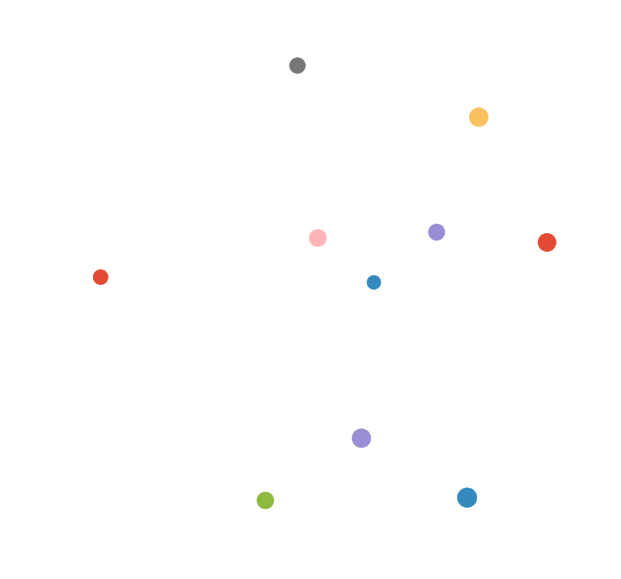

In [10]:
plot_nd(mark_data, view0_data, outer_product(compute_outer_product_shader, RESULT_TYPE))

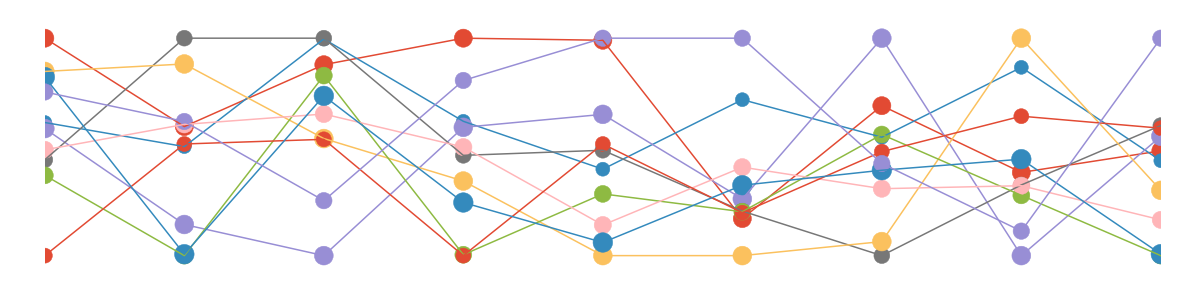

In [11]:
plot_nd(mark_data, view1_data, outer_product(compute_outer_product_shader, RESULT_TYPE), size=(20,5), joins=[list(range(M))])

And let's try a different composition function (this time, we take the color from the view):

In [12]:
def compute_outer_product_shader(view, mark):
    position = mark['position'] @ view['transform']
    size = mark['size']
    color = view['color']
    return (position, size, color)

And we are ready to plot:

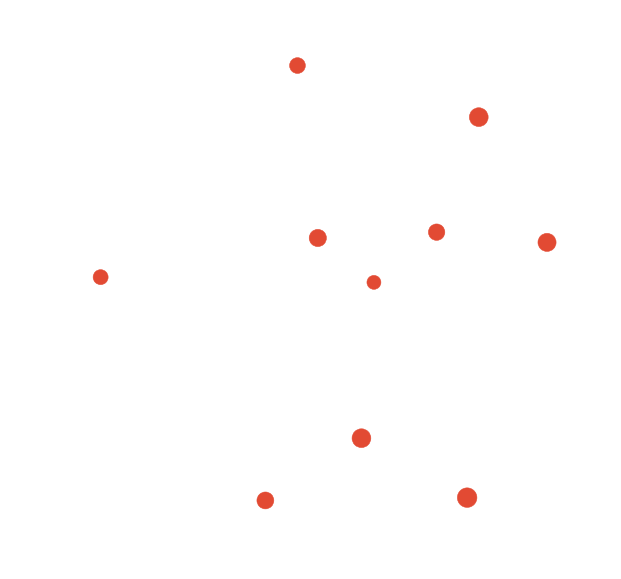

In [13]:
plot_nd(mark_data, view0_data, outer_product(compute_outer_product_shader, RESULT_TYPE))

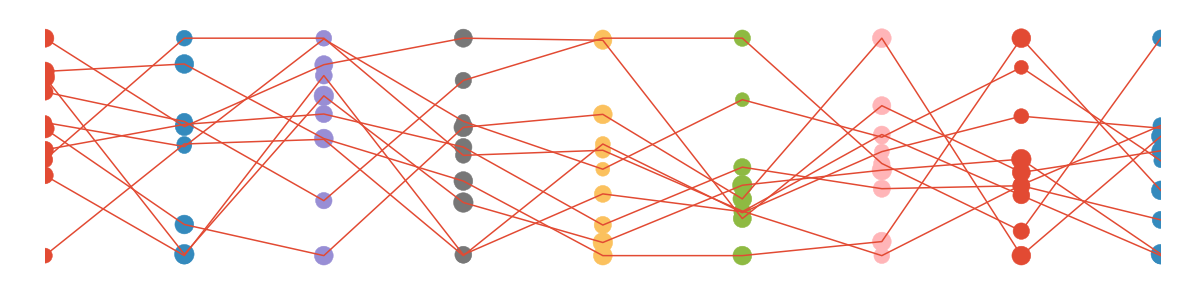

In [14]:
plot_nd(mark_data, view1_data, outer_product(compute_outer_product_shader, RESULT_TYPE), size=(20,5), joins=[list(range(M))])

### Result
We have updated `plot_nd` to work with complex object that can have various visual attributes (color, size, etc.), and relaced matrix multiplication with a fully customisable composition function, that could be performed in a shader on the GPU.